In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm
import IPython.display as ipd

1. Exploratory Data Analysis (EDA)

1.1. Validating that each noisy audio file has a matching clean version

In [2]:

noisy_dir = "noisy_trainset_28spk_wav"
clean_dir = "clean_trainset_28spk_wav"

noisy_files = sorted([os.path.splitext(f)[0] for f in os.listdir(noisy_dir) if f.endswith('.wav')])
clean_files = sorted([os.path.splitext(f)[0] for f in os.listdir(clean_dir) if f.endswith('.wav')])

missing_in_clean = [f for f in noisy_files if f not in clean_files]
missing_in_noisy = [f for f in clean_files if f not in noisy_files]

if not missing_in_clean and not missing_in_noisy:
    print("✅ All files have matching counterparts.")
else:
    print("⚠️ Mismatches found:")
    if missing_in_clean:
        print("No matching clean file for:", missing_in_clean)
    if missing_in_noisy:
        print("No matching noisy file for:", missing_in_noisy)

✅ All files have matching counterparts.


1.2. Checking our dataset's files length

In [3]:
noisy_trainset_files = os.listdir("noisy_trainset_28spk_wav")
clean_trainset_files = os.listdir("clean_trainset_28spk_wav")

noisy_testset_files = os.listdir("noisy_testset_wav")
clean_testset_files = os.listdir("clean_testset_wav")


print("noisy trainset file length", len(noisy_trainset_files))
print("clean trainset file length", len(clean_trainset_files))

print("noisy testset file length", len(noisy_testset_files))
print("clean testset file length", len(clean_testset_files))

noisy trainset file length 11572
clean trainset file length 11572
noisy testset file length 824
clean testset file length 824


1.3. Checking the properties of an audio file in the dataset

In [ ]:
first_audio = os.listdir(noisy_dir)[0]  
audio_path = os.path.join(noisy_dir, first_audio)

# Get info
info = sf.info(audio_path)

# Print details
print("File:", audio_path)
print("Sample Rate:", info.samplerate)
print("Channels:", info.channels)
print("Duration (seconds):", info.duration)
print("Subtype (bit depth):", info.subtype)

File: noisy_trainset_28spk_wav\p226_001.wav
Sample Rate: 48000
Channels: 1
Duration (seconds): 2.28
Subtype (bit depth): PCM_16


1.4. Playing a noisy audio and its clean version

In [6]:
sample_noisy_files = noisy_trainset_files[:5]
sample_clean_files= clean_trainset_files[:5]

print("Sample noisy files:", sample_noisy_files)
print("Sample clean files:", sample_clean_files)

Sample noisy files: ['p226_001.wav', 'p226_002.wav', 'p226_003.wav', 'p226_004.wav', 'p226_005.wav']
Sample clean files: ['p226_001.wav', 'p226_002.wav', 'p226_003.wav', 'p226_004.wav', 'p226_005.wav']


In [ ]:
# Build the path to the first noisy file
noisy_file_path = os.path.join(noisy_dir, sample_noisy_files[0])
print(f"Playing the first noisy audio: {sample_noisy_files[0]}")

# Play audio 
ipd.Audio(noisy_file_path)

Playing the first noisy audio: p226_001.wav


In [ ]:
# Build the path to the first noisy file
noisy_file_path = os.path.join(clean_dir, sample_noisy_files[0])
print(f"Playing the first clean audio: {sample_clean_files[0]}")

# Play audio 
ipd.Audio(noisy_file_path)

Playing the first clean audio: p226_001.wav


1.5. Analyze and Print statistics for clean and noisy audio files

In [11]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to analyze a single file
def analyze_single_file(file_path):
    try:
        info = sf.info(file_path)
        return info.duration  # Return the duration in seconds
    except Exception as e:
        return None

# Function to compute percentages and counts based on length ranges
def calculate_length_percentages_and_counts(lengths, bins=[0, 5, 10, 15, 20, 30]):

    total_files = len(lengths)
    length_data = {}

    for i in range(len(bins) - 1):
        lower_bound = bins[i]
        upper_bound = bins[i + 1]
        count = sum(lower_bound <= length < upper_bound for length in lengths)
        percentage = (count / total_files) * 100
        length_data[f"{lower_bound}-{upper_bound} seconds"] = (count, percentage)

    # Handle the last bin (greater than or equal to the upper bound)
    count = sum(length >= bins[-1] for length in lengths)
    percentage = (count / total_files) * 100
    length_data[f">={bins[-1]} seconds"] = (count, percentage)

    return length_data

# Function to analyze all files in parallel
def analyze_audio_lengths_parallel(directory, num_workers=8):
    lengths = []
    # Precompute the list of .wav files
    files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    file_paths = [os.path.join(directory, f) for f in files]

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(analyze_single_file, file_path) for file_path in file_paths]
        # Only collect results without printing progress
        for future in as_completed(futures):
            length = future.result()
            if length is not None:
                lengths.append(length)

    return lengths

# Function to print statistics for audio durations
def print_statistics(lengths, dataset_name):
    print(f"\n{dataset_name}:")
    print(f"Average length: {sum(lengths) / len(lengths):.2f} seconds")
    print(f"Minimum length: {min(lengths):.2f} seconds")
    print(f"Maximum length: {max(lengths):.2f} seconds")

    # Calculate percentages and counts
    length_data = calculate_length_percentages_and_counts(lengths, bins=[0, 5, 10, 15, 20, 30])
    print("\nLength Distribution (Percentages and Counts):")
    for range_, (count, percentage) in length_data.items():
        print(f"{range_}: {count} files ({percentage:.2f}%)")

In [12]:
# Paths to clean and noisy train directories
clean_train = 'clean_trainset_28spk_wav'
noisy_train = 'noisy_trainset_28spk_wav'

# Analyze lengths for clean and noisy audio files
clean_lengths = analyze_audio_lengths_parallel(clean_train)
noisy_lengths = analyze_audio_lengths_parallel(noisy_train)

# Print statistics for clean and noisy datasets
print_statistics(clean_lengths, "Clean Train Set")
print_statistics(noisy_lengths, "Noisy Train Set")


Clean Train Set:
Average length: 2.92 seconds
Minimum length: 1.09 seconds
Maximum length: 15.11 seconds

Length Distribution (Percentages and Counts):
0-5 seconds: 11141 files (96.28%)
5-10 seconds: 407 files (3.52%)
10-15 seconds: 23 files (0.20%)
15-20 seconds: 1 files (0.01%)
20-30 seconds: 0 files (0.00%)
>=30 seconds: 0 files (0.00%)

Noisy Train Set:
Average length: 2.92 seconds
Minimum length: 1.09 seconds
Maximum length: 15.11 seconds

Length Distribution (Percentages and Counts):
0-5 seconds: 11141 files (96.28%)
5-10 seconds: 407 files (3.52%)
10-15 seconds: 23 files (0.20%)
15-20 seconds: 1 files (0.01%)
20-30 seconds: 0 files (0.00%)
>=30 seconds: 0 files (0.00%)


In [13]:
# Paths to clean and noisy test directories
clean_test = 'clean_testset_wav'
noisy_test = 'noisy_testset_wav'

# Analyze lengths for clean and noisy audio files
clean_lengths = analyze_audio_lengths_parallel(clean_test)
noisy_lengths = analyze_audio_lengths_parallel(noisy_test)

# Print statistics for clean and noisy datasets
print_statistics(clean_lengths, "Clean Test Set")
print_statistics(noisy_lengths, "Noisy Test Set")


Clean Test Set:
Average length: 2.51 seconds
Minimum length: 1.24 seconds
Maximum length: 9.77 seconds

Length Distribution (Percentages and Counts):
0-5 seconds: 807 files (97.94%)
5-10 seconds: 17 files (2.06%)
10-15 seconds: 0 files (0.00%)
15-20 seconds: 0 files (0.00%)
20-30 seconds: 0 files (0.00%)
>=30 seconds: 0 files (0.00%)

Noisy Test Set:
Average length: 2.51 seconds
Minimum length: 1.24 seconds
Maximum length: 9.77 seconds

Length Distribution (Percentages and Counts):
0-5 seconds: 807 files (97.94%)
5-10 seconds: 17 files (2.06%)
10-15 seconds: 0 files (0.00%)
15-20 seconds: 0 files (0.00%)
20-30 seconds: 0 files (0.00%)
>=30 seconds: 0 files (0.00%)


1.6. Plot histograms of audio durations for both clean and noisy files

100%|██████████| 11572/11572 [00:40<00:00, 287.65it/s]


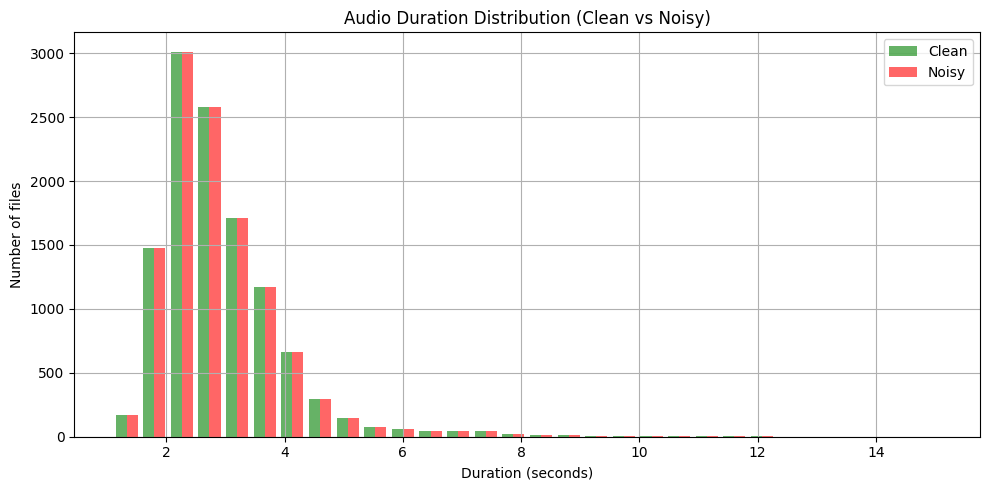

In [14]:
def get_durations(audio_dir, sr=16000):
    durations = []
    for file_name in tqdm(os.listdir(audio_dir)):
        if file_name.endswith('.wav'):
            file_path = os.path.join(audio_dir, file_name)
            try:
                y, _ = librosa.load(file_path, sr=sr)
                durations.append(librosa.get_duration(y=y, sr=sr))
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    return durations

# Paths to your dataset
clean_path = "clean_trainset_28spk_wav"
noisy_path = "noisy_trainset_28spk_wav"

# Get durations
clean_durations = get_durations(clean_path)
noisy_durations = get_durations(noisy_path)

# Plotting
plt.figure(figsize=(10, 5))
plt.hist([clean_durations, noisy_durations], bins=30, label=['Clean', 'Noisy'], color=['green', 'red'], alpha=0.6)
plt.title("Audio Duration Distribution (Clean vs Noisy)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of files")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The audio duration distribution shows that most clean and noisy files are short (2–4 seconds), with very few exceeding 6 seconds. The distribution is right-skewed, meaning there are fewer long audio samples.

1.7. Comparing waveforms between noisy and clean audios

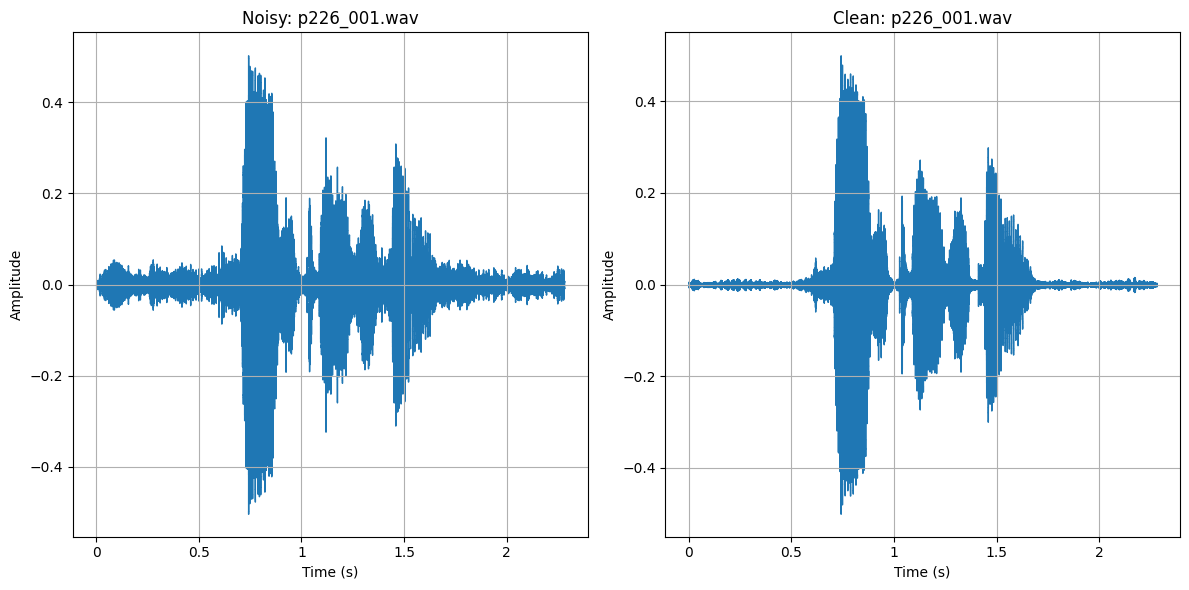

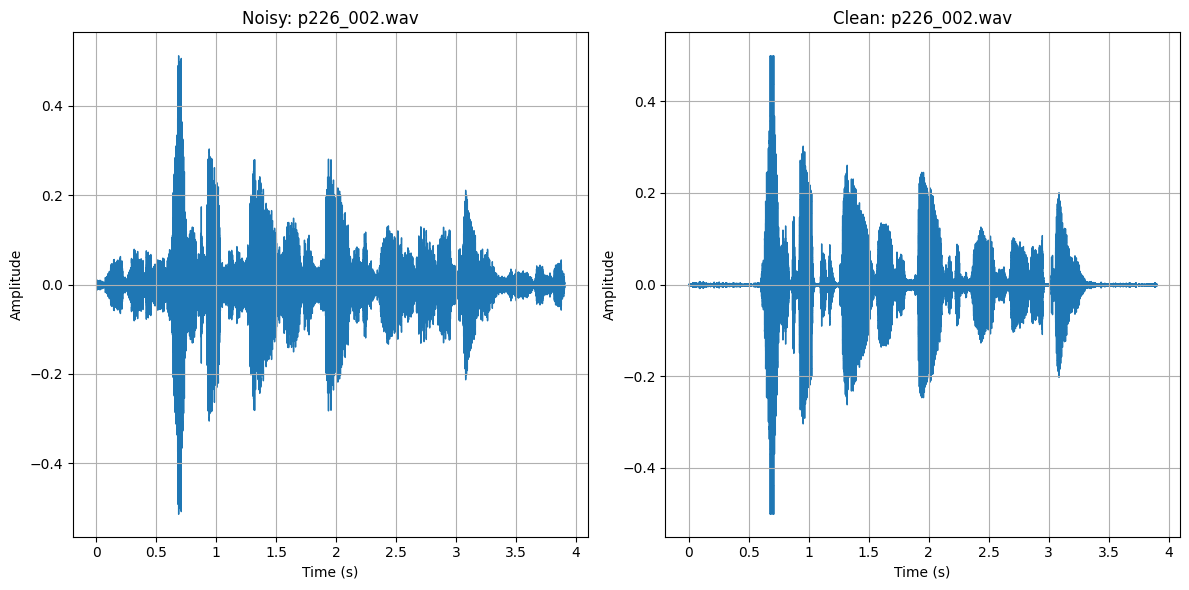

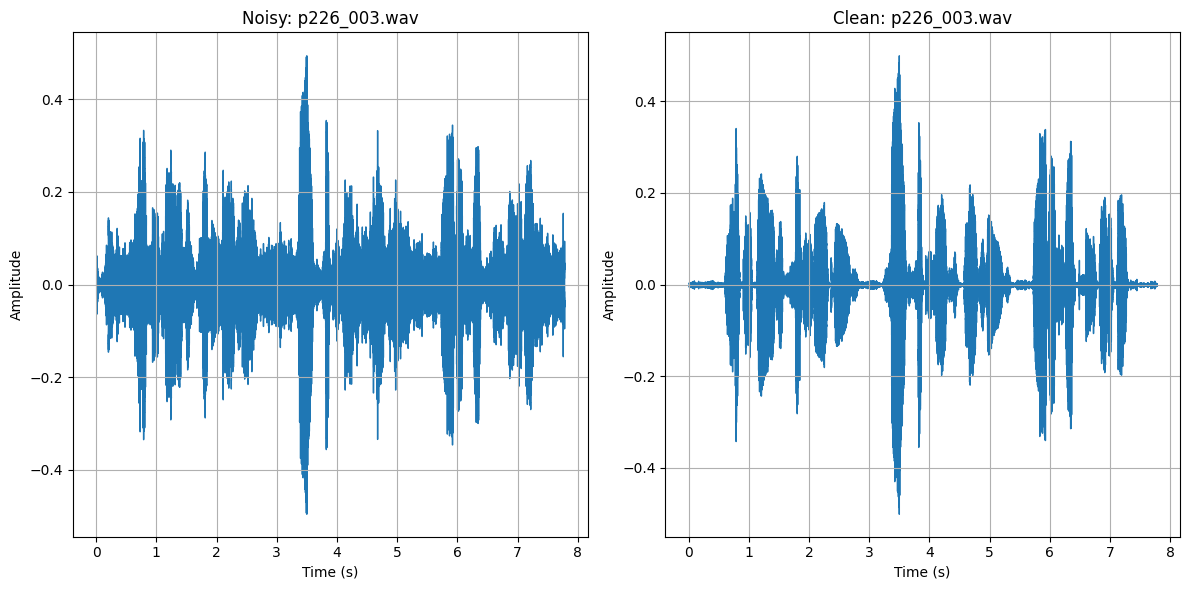

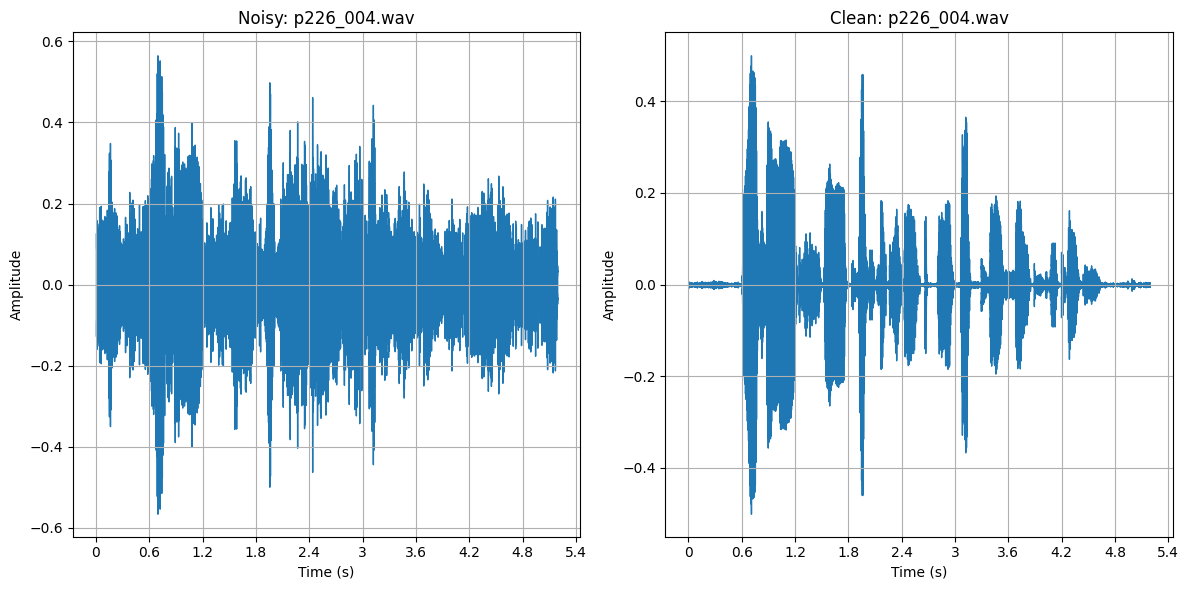

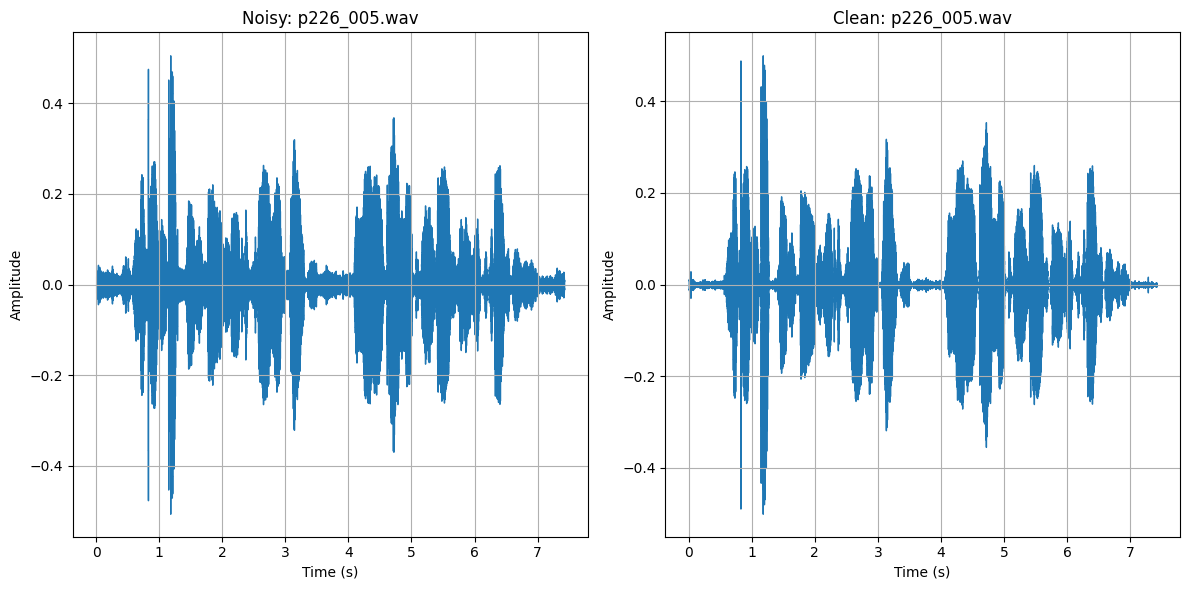

In [15]:
for noisy_file, clean_file in zip(sample_noisy_files, sample_clean_files):
    noisy_file_path = os.path.join("noisy_trainset_28spk_wav", noisy_file)
    clean_file_path = os.path.join("clean_trainset_28spk_wav", clean_file)

    noisy_audio_data, sr_noisy = librosa.load(noisy_file_path, sr=None)
    clean_audio_data, sr_clean = librosa.load(clean_file_path, sr=None)

    plt.figure(figsize=(12, 6))

    # Plot the noisy waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(noisy_audio_data, sr=sr_noisy)
    plt.title(f"Noisy: {noisy_file}")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Plot the clean
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(clean_audio_data, sr=sr_clean)
    plt.title(f"Clean: {clean_file}")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

From the waveform comparison of noisy and clean audio signals, we observe that:

Noisy waveform: Dense and chaotic due to constant background noise.
Clean waveform: Clearer speech with visible silence and well-defined segments.

1.8. Comparing Spectrograms between noisy and clean audios

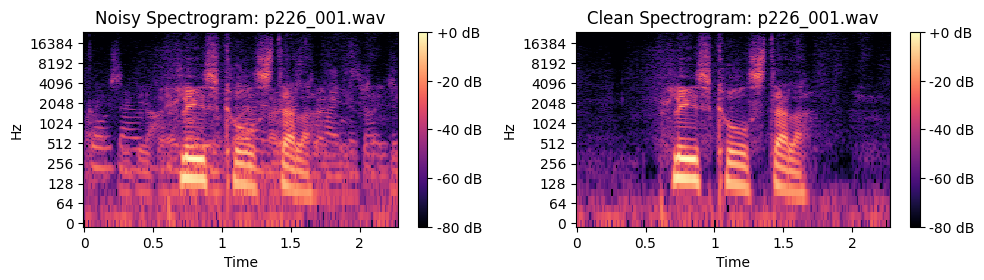

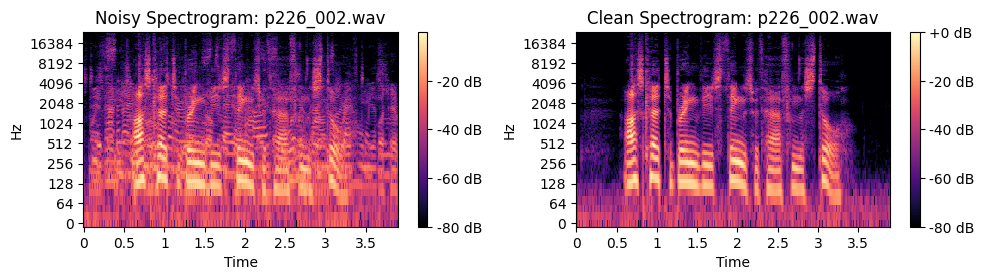

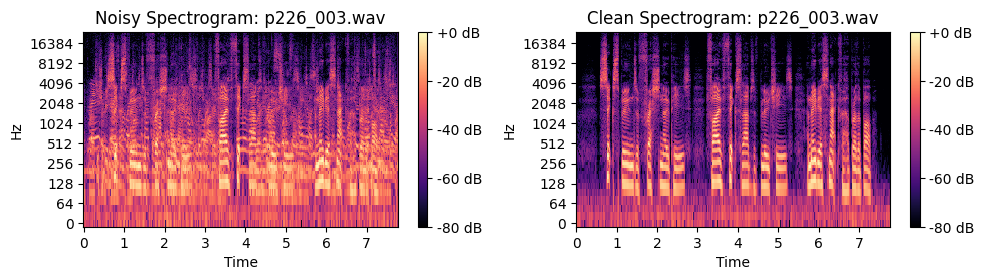

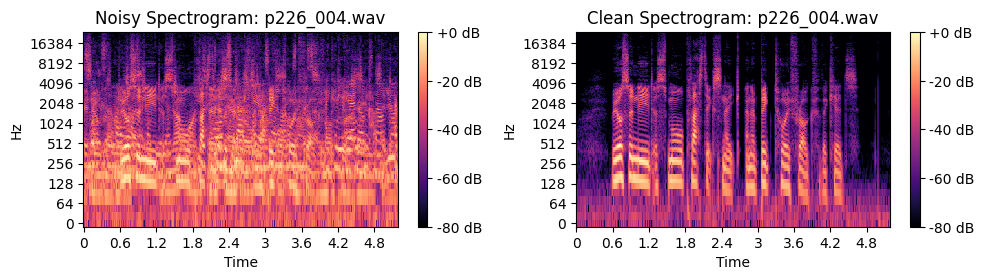

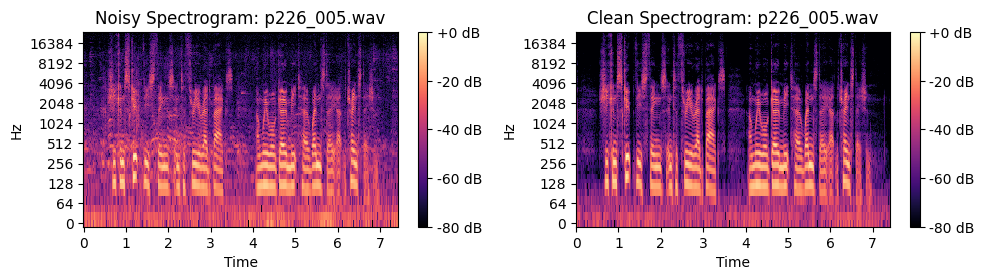

In [16]:
for noisy_file, clean_file in zip(sample_noisy_files, sample_clean_files):

    noisy_file_path = os.path.join("noisy_trainset_28spk_wav", noisy_file)
    clean_file_path = os.path.join("clean_trainset_28spk_wav", clean_file)

    noisy_audio_data, sr_noisy = librosa.load(noisy_file_path, sr=None)
    clean_audio_data, sr_clean = librosa.load(clean_file_path, sr=None)

    # Compute spectrograms (Short-Time Fourier Transform)
    noisy_spectrogram = librosa.stft(noisy_audio_data)
    clean_spectrogram = librosa.stft(clean_audio_data)

    # Convert to dB scale
    noisy_db = librosa.amplitude_to_db(abs(noisy_spectrogram), ref=np.max)
    clean_db = librosa.amplitude_to_db(abs(clean_spectrogram), ref=np.max)

    plt.figure(figsize=(10, 5))

    # Plot the noisy spectrogram
    plt.subplot(2, 2, 1)
    librosa.display.specshow(noisy_db, sr=sr_noisy, x_axis="time", y_axis="log", cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Noisy Spectrogram: {noisy_file}")

    # Plot the clean spectrogram
    plt.subplot(2, 2, 2)
    librosa.display.specshow(clean_db, sr=sr_clean, x_axis="time", y_axis="log", cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Clean Spectrogram: {clean_file}")

    plt.tight_layout()
    plt.show()

These plots shows that clean spectrograms reveal speech patterns more distinctly, while noisy spectrograms exhibit blurred frequency content due to the added noise.

1.9. Comparing waveforms before and after normalizing amplitudes to the range of [ -1, 1]

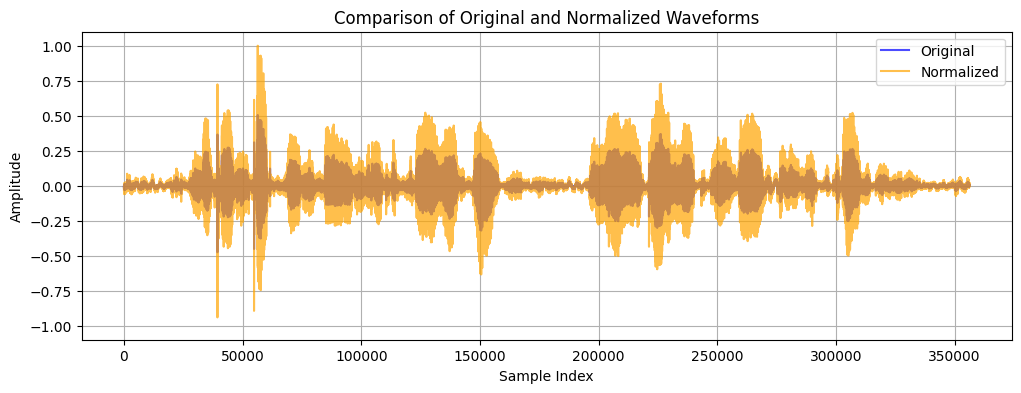

Original Audio:


Normalized Audio:


In [17]:
import torchaudio
from IPython.display import Audio, display

def normalize_audio(audio):
    # Normalizes the audio amplitude to the range [-1, 1].
    max_val = audio.abs().max()
    if max_val > 0:
        return audio / max_val
    return audio

# Load an example audio file
audio_path = os.path.join("noisy_trainset_28spk_wav", sample_noisy_files[4])
audio, sample_rate = torchaudio.load(audio_path)

# Normalize the audio
normalized_audio = normalize_audio(audio)

# plot the comparision of original and normalized waveforms
plt.figure(figsize=(12, 4))
plt.plot(audio.numpy().squeeze(), color='blue', label="Original", alpha=0.7)
plt.plot(normalized_audio.numpy().squeeze(), color='orange', label="Normalized", alpha=0.7)
plt.title("Comparison of Original and Normalized Waveforms")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.ylim(-1.1, 1.1)  # Fix y-axis range
plt.legend()
plt.grid(True)
plt.show()

# Listen to the original and normalized audio
print("Original Audio:")
display(Audio(audio.numpy().squeeze(), rate=sample_rate))

print("Normalized Audio:")
display(Audio(normalized_audio.numpy().squeeze(), rate=sample_rate))

Serialized Data

In [18]:
folder_path = 'serialized_train_data' 
file_count = len([
    f for f in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, f))
])
print(f"Number of files: {file_count}")

Number of files: 48640


In [19]:
folder_path = 'serialized_test_data' 
file_count = len([
    f for f in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, f))
])
print(f"Number of files: {file_count}")

Number of files: 2805


In [20]:
import random
data_path = 'serialized_train_data' 

file_list = [f for f in os.listdir(data_path) if f.endswith('.npy')]
rand_file = random.choice(file_list)
file_path = os.path.join(data_path, rand_file)

data = np.load(file_path)

print(f"File name: {rand_file}")
print(f"Shape: {data.shape} --> Format: (2, {data.shape[1]}) [clean, noisy]")
print(f"Data type: {data.dtype}")
print("Type of object:", type(data))
print("Sample stats:")

clean, noisy = data[0], data[1]
print("Clean signal:")
print(f"  First 20 values: {clean[:20]}")

print("Noisy signal:")
print(f"  First 20 values: {noisy[:20]}")

File name: p258_257.wav_0.npy
Shape: (2, 16384) --> Format: (2, 16384) [clean, noisy]
Data type: float32
Type of object: <class 'numpy.ndarray'>
Sample stats:
Clean signal:
  First 20 values: [0.00046335 0.00071241 0.00056212 0.0003918  0.00037346 0.00083558
 0.00106625 0.0013332  0.00168546 0.00168391 0.00130804 0.00137934
 0.0013863  0.00141105 0.00156416 0.00155629 0.00132287 0.00096156
 0.00074368 0.00063974]
Noisy signal:
  First 20 values: [-0.07423162 -0.12317199 -0.10865723 -0.119003   -0.11285309 -0.11810065
 -0.11412001 -0.11787391 -0.11567254 -0.11824163 -0.11752423 -0.11887839
 -0.118138   -0.11926259 -0.11925782 -0.11925857 -0.11963982 -0.11961534
 -0.11983986 -0.11897213]


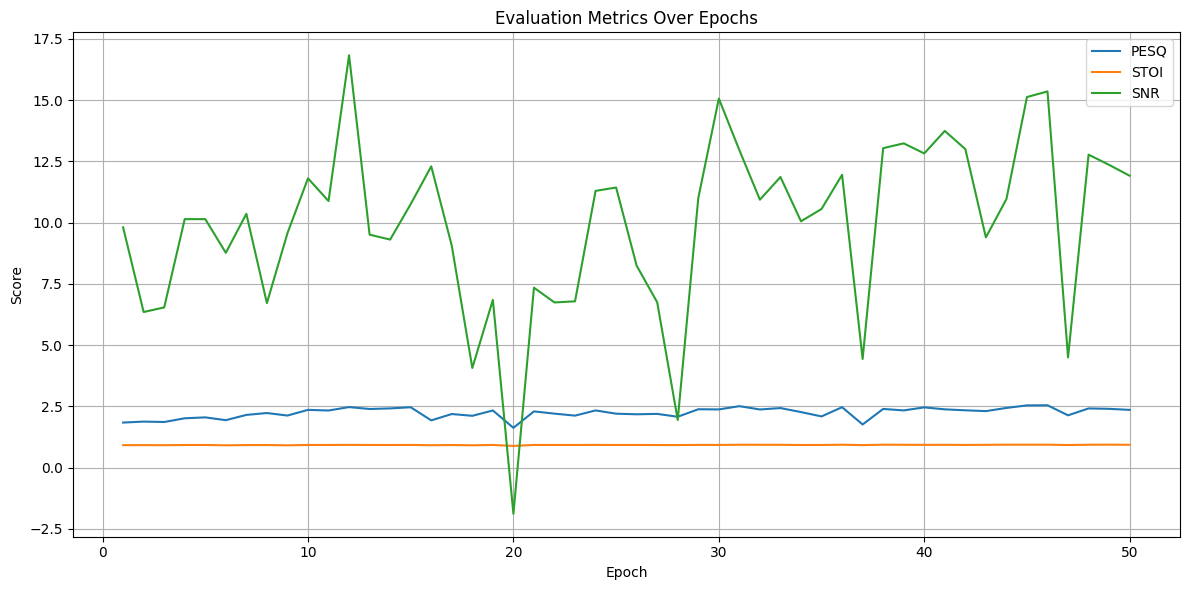

In [2]:
# Load the data
df = pd.read_csv("test_metrics.csv") 

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(df['epoch'], df['pesq'], label='PESQ', color='tab:blue')
plt.plot(df['epoch'], df['stoi'], label='STOI', color='tab:orange')
plt.plot(df['epoch'], df['snr'], label='SNR', color='tab:green')

plt.title("Evaluation Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
